In [282]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [283]:
data=pd.read_csv('/content/BTC-USD Training Data.csv',header=0, index_col=0)

In [284]:
data = data[-2600:-400] 
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600
...,...,...,...,...,...,...
2020-11-23,18370.017578,18711.425781,18000.796875,18364.121094,18364.121094,42741112308
2020-11-24,18365.015625,19348.271484,18128.656250,19107.464844,19107.464844,51469565009
2020-11-25,19104.410156,19390.964844,18581.146484,18732.121094,18732.121094,43710357371


In [285]:
n,p=data.shape
print(n,p)

1793 6


In [286]:
data.isnull().sum()*100/n

Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
dtype: float64

In [287]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1793 entries, 2016-01-01 to 2020-11-27
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1793 non-null   float64
 1   High       1793 non-null   float64
 2   Low        1793 non-null   float64
 3   Close      1793 non-null   float64
 4   Adj Close  1793 non-null   float64
 5   Volume     1793 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 98.1+ KB


In [288]:
# correlation read
corr = data.corr()
#pd.plotting.scatter_matrix(corr);
corr

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998567,0.997697,0.997039,0.997039,0.677521
High,0.998567,1.000000,0.997070,0.998697,0.998697,0.677147
Low,0.997697,0.997070,1.000000,0.998443,0.998443,0.680570
Close,0.997039,0.998697,0.998443,1.000000,1.000000,0.678530
Adj Close,0.997039,0.998697,0.998443,1.000000,1.000000,0.678530
Volume,0.677521,0.677147,0.680570,0.678530,0.678530,1.000000


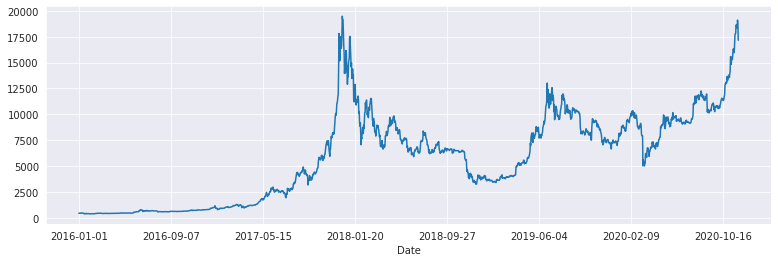

In [289]:
# visualisation
plt.figure(figsize=(13,4))
data['Open'].plot()
#data['Volume'].plot()

(1430,)
(359,)
17153.914063


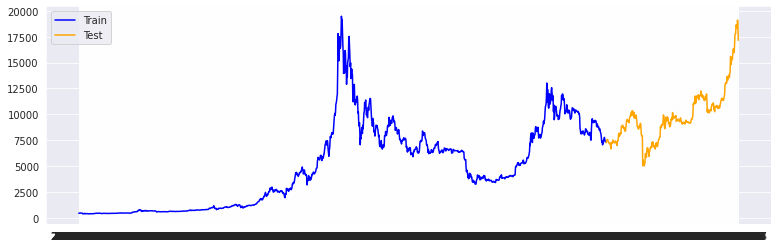

In [290]:
# train test split
k = int(n*0.8) #index de 80%
train = data['Open'][4:k] #80% of the data %I manipulated the data to have multiples of 5 suitable for 5 working days
test = data['Open'][k:] # 20% of the date

print(train.shape)
print(test.shape)
print(test[-1])

#visualisation
plt.figure(figsize=(13,4))
plt.plot(train, 'blue', test, 'orange')
plt.legend(["Train","Test"])
plt.show()

In [291]:
# Data normalisation
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(0, 1))
training_set_scaled = scalar.fit_transform(train.to_numpy().reshape(-1, 1))
test_set_scaled = scalar.transform(test.to_numpy().reshape(-1,1))
#test_set_scaled.shape

In [292]:
# Creation of input vector adapted to LSTM work: ie. creation of an nline matrix, 60 input, 1 output
# Creating a data structure with 60 time-steps and 30 output for the LSTM model
# ie. if I want to predict from the current date d to d+30 

times_steps = 30 #define the number of time-steps: with 60 time-steps the network trains in 8min, with 120 it takes 30min
jour_predit = 30

X_train = []
y_train = []
for i in range(times_steps, k-jour_predit-3):
    X_train.append(training_set_scaled[i-times_steps:i, 0])
    y_train.append(np.array(training_set_scaled[i:i+jour_predit, 0]))
X_train = np.array(X_train)
y_train = np.array(y_train)

#y_train = y_train[]
#y_train = np.array(y_train)
#print(y_train.shape)
#print(X_train.shape)

#visualisation de ces vecteurs:
#plt.plot(X_train) 
#plt.plot(y_train)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(1371, 30, 1)
(1371, 30, 1)


In [293]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
#from keras.models import *

In [294]:
# Creation of my network: 4 LSTM and 1 Dense (outputlayer)

model = Sequential()
# Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(y_train.shape[1]))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 50, batch_size = 200) #originally it was epochs=100 and batch size 32 but i got it
# changed to decrease training time from 30min to 8min
#to train on aa.us use epoch=50 and batch_size 400

#To add: Save the model

Epoch 1/50
7/7 [==============================] - 8s 162ms/step - loss: 0.0836
Epoch 2/50
7/7 [==============================] - 1s 162ms/step - loss: 0.0448
Epoch 3/50
7/7 [==============================] - 1s 163ms/step - loss: 0.0264
Epoch 4/50
7/7 [==============================] - 1s 163ms/step - loss: 0.0202
Epoch 5/50
7/7 [==============================] - 1s 160ms/step - loss: 0.0161
Epoch 6/50
7/7 [==============================] - 1s 162ms/step - loss: 0.0151
Epoch 7/50
7/7 [==============================] - 1s 161ms/step - loss: 0.0138
Epoch 8/50
7/7 [==============================] - 1s 162ms/step - loss: 0.0132
Epoch 9/50
7/7 [==============================] - 1s 163ms/step - loss: 0.0124
Epoch 10/50
7/7 [==============================] - 1s 163ms/step - loss: 0.0120
Epoch 11/50
7/7 [==============================] - 1s 164ms/step - loss: 0.0114
Epoch 12/50
7/7 [==============================] - 1s 163ms/step - loss: 0.0110
Epoch 13/50
7/7 [==============================] 

In [295]:
inputs = np.concatenate((training_set_scaled[-times_steps:],test_set_scaled),axis=0) 

X_test = []
for i in range(times_steps, len(inputs)+1):
    X_test.append(inputs[i-times_steps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
print(test.values.shape)

(360, 30, 1)
(359,)


In [296]:
predicted_stock_price = model.predict(X_test[:-30]) # is predicted up to -30 days from the end of the test set
predicted_stock_price = scalar.inverse_transform(predicted_stock_price)
print(predicted_stock_price.shape)

(330, 30)


In [297]:
# construction of a matrix taking up the structure of the predictions to test the results
mat_test = []

for i in range(n-k-jour_predit+1):
    mat_test.append(np.array(test[i:i+jour_predit]))
    
mat_test = np.array(mat_test)

(330, 30)
(330, 30)


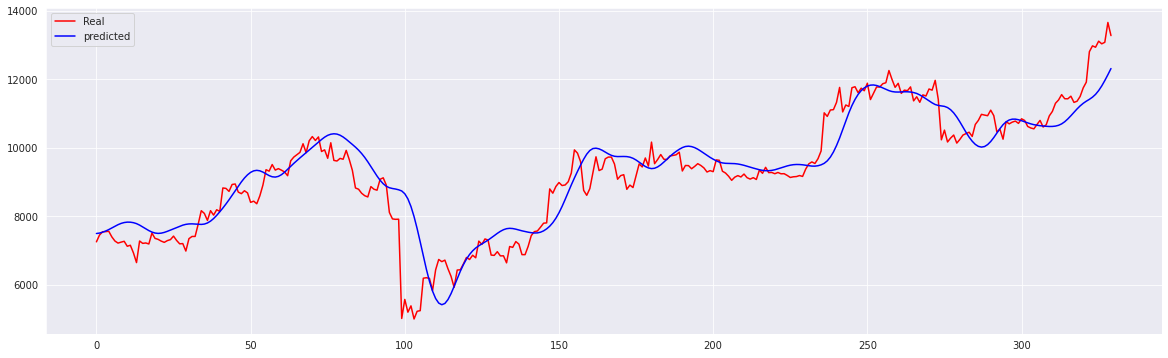

In [298]:
# viz results: comparison of the predicted 1st day vs the actual value of this day
plt.figure(figsize=(20, 6))
plt.plot(mat_test[:,0], color = 'red', label = 'Real') # Add a number of days here if you want to see p
plt.plot(predicted_stock_price[:,0], color = 'blue', label = 'predicted')
plt.legend()

print(predicted_stock_price.shape)
print(mat_test.shape)

(330, 30)
(330, 30)


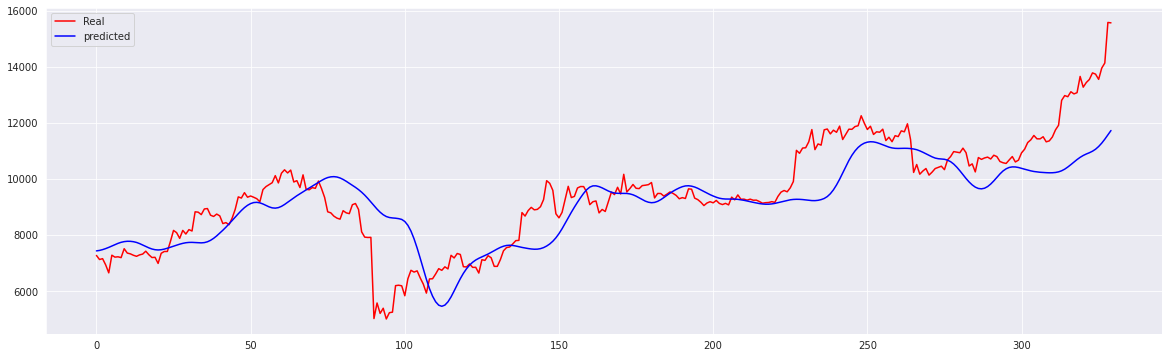

In [299]:
# viz results: comparison of the predicted 10th day vs the actual value of that day
plt.figure(figsize=(20, 6))
plt.plot(mat_test[:,9], color = 'red', label = 'Real') # Add a number of days here if you want to see p
plt.plot(predicted_stock_price[:,9], color = 'blue', label = 'predicted')
plt.legend()

print(predicted_stock_price.shape)
print(mat_test.shape)

(330, 30)
(330, 30)


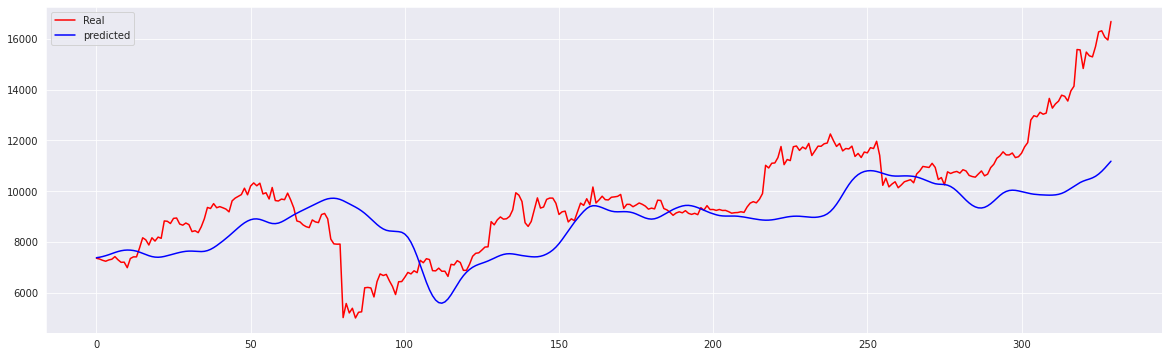

In [300]:
# viz results: comparison of the predicted 20th day vs the actual value of this day
plt.figure(figsize=(20, 6))
plt.plot(mat_test[:,19], color = 'red', label = 'Real') # Add here a number of days if you want to see p
plt.plot(predicted_stock_price[:,19], color = 'blue', label = 'predicted')
plt.legend()

print(predicted_stock_price.shape)
print(mat_test.shape)

(330, 30)
(330, 30)


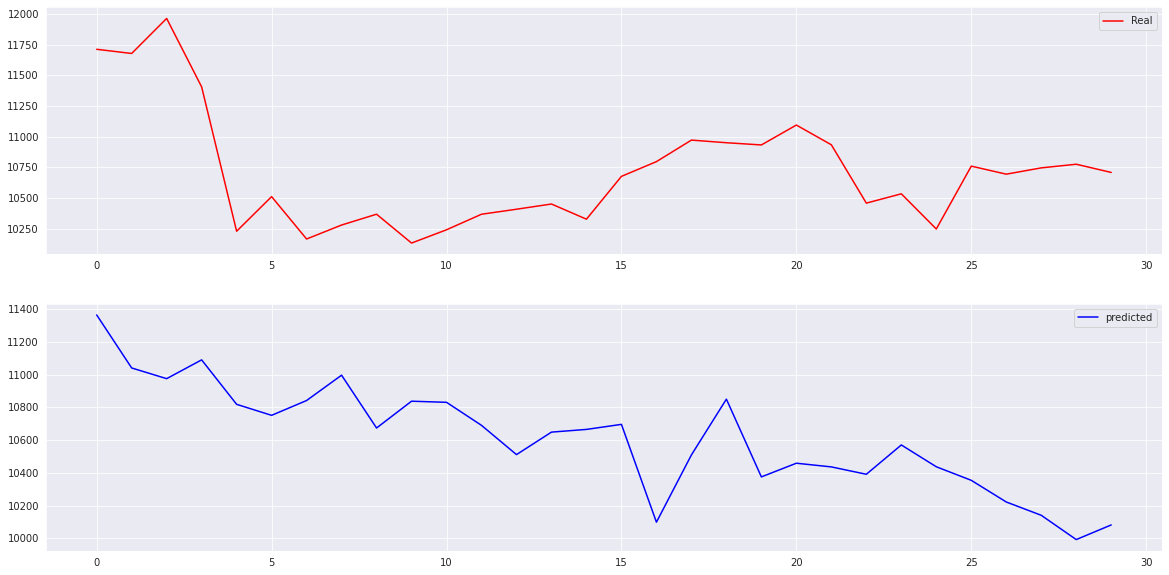

<Figure size 1440x1440 with 0 Axes>

In [301]:
# viz results: comparison of a predicted vector vs real vector
fig, (ax1, ax2) = plt.subplots(2,figsize=(20, 10))
#fig.suptitle('Vertically stacked subplots')
plt.figure(figsize=(20, 20))
ax1.plot(mat_test[270,:], color = 'red', label = 'Real')
ax2.plot(predicted_stock_price[270,:], color = 'blue', label = 'predicted')
ax1.legend()
ax2.legend()


print(predicted_stock_price.shape)
print(mat_test.shape)

In [302]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		# calculate rmse
		rmse = sqrt(mse)
		# store
		scores.append(rmse)
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

score, scores = evaluate_forecasts(mat_test,predicted_stock_price)
print("General RMSE: ", score,  "\nRMSE for each day\n", np.array(scores).reshape(-1,1))


General RMSE:  1633.229188558603 
RMSE for each day
 [[ 699.33152787]
 [ 765.62439172]
 [ 817.7426897 ]
 [ 860.74302231]
 [ 938.13656749]
 [1009.97140847]
 [1010.5385582 ]
 [1037.43920935]
 [1151.18645953]
 [1186.80657891]
 [1255.7664166 ]
 [1310.22561272]
 [1410.29305079]
 [1414.10688527]
 [1478.61180596]
 [1540.63966943]
 [1746.53678754]
 [1662.65497827]
 [1655.06471975]
 [1834.55899547]
 [1835.08666596]
 [1895.44060225]
 [1973.94809096]
 [1985.92490756]
 [2099.75716537]
 [2162.6763694 ]
 [2274.85153714]
 [2379.75104614]
 [2480.07370895]
 [2483.843061  ]]


In [303]:
testData = pd.read_csv('/content/BTC-USD Out of Time Testing 1st Jan 2022 to 4th Feb 2022.csv') #importing the test data
testData["Close"]=pd.to_numeric(testData.Close,errors='coerce') #turning the close column to numerical type
testData = testData.dropna() #droping the NA values
testData = testData.iloc[:,4:5] #selecting the closing prices for testing
y_test = testData.iloc[60:,0:].values #selecting the labels 
#input array for the model
inputClosing = testData.iloc[:,0:].values 
inputClosing_scaled = scalar.transform(inputClosing)
inputClosing_scaled.shape
X_test = []
length = len(testData)
timestep = 60
X_test = []
for i in range(times_steps, len(inputs)+1):
    X_test.append(inputs[i-times_steps:i, 0])
X_test = np.array(X_test)

In [304]:
print(X_test.shape)
print(test.values.shape)

(360, 30)
(359,)


In [305]:
y_pred = model.predict(X_test)

In [306]:
predicted_price = scalar.inverse_transform(y_pred) #inversing the scaling transformation for ploting 

In [307]:
predicted_price

array([[ 7496.362 ,  7359.4673,  7381.0903, ...,  7470.569 ,  7451.9165,
         7535.72  ],
       [ 7509.124 ,  7374.638 ,  7401.141 , ...,  7486.332 ,  7470.788 ,
         7554.8086],
       [ 7534.3965,  7401.4263,  7432.189 , ...,  7512.555 ,  7499.898 ,
         7584.4194],
       ...,
       [15892.01  , 15370.536 , 15264.485 , ..., 12960.883 , 12538.867 ,
        12607.448 ],
       [16052.811 , 15525.71  , 15417.424 , ..., 13047.481 , 12613.76  ,
        12679.898 ],
       [16159.705 , 15629.87  , 15517.998 , ..., 13092.759 , 12652.71  ,
        12714.313 ]], dtype=float32)